In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from CDAE import AutoEncoder
from tqdm import trange
from utils import *
from sklearn.cluster import KMeans, spectral_clustering
from sklearn.decomposition import PCA

/Users/larry/Py3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Data preprocessing

In [2]:
import math
def get_map(list_):
    map_ = {}
    for idx, ident in enumerate(list_):
        map_[ident] = idx
        
    return map_

def get_matrix(data):
    matrix = np.zeros((total_usr, total_item), dtype=np.float32)
    for line in data:
        uid = user_map[line[0]]
        iid = item_map[line[1]]
        matrix[uid, iid] = 1
    
    return matrix

def train_test_split(df, time_interval, split_rate=0.5):
    start_time = min(df['timestamp'])
    end_time = max(df['timestamp'])
    time_elapse = (end_time-start_time) // time_interval
    split_time = start_time + math.floor(time_elapse * (1-split_rate)) * time_interval
    
    while split_time < end_time:
        df_train = df[df['timestamp'] < split_time]
        df_train = df_train[df_train['timestamp'] >= start_time]
        
        df_test_1 = df[df['timestamp'] >= split_time - 3*time_interval]
        df_test_1 = df_test_1[df_test_1['timestamp'] < split_time]
        
        df_test_2 = df[df['timestamp'] >= split_time]
        df_test_2 = df_test_2[df_test_2['timestamp'] < split_time + time_interval]
        
        # start_time += time_interval
        # split_time = start_time + math.floor(time_elapse * (1-split_rate)) * time_interval
        split_time += time_interval
        
        yield df_train, df_test_1, df_test_2

In [3]:
df = pd.read_csv('../data/itri/rating_itri.csv')
df['freq'] = df.groupby('uid')['uid'].transform('count')  # count frequncy by column's values
df = df[df['freq'] > 5]  # remove row which corresponding frequence < 5
df_array = df.as_matrix()

userList = df['uid'].unique()
itemList = df['iid'].unique()

total_usr = len(df['uid'].unique())
total_item = len(df['iid'].unique())

user_map = get_map(userList)
item_map = get_map(itemList)
    

sparsity = len(df)/(total_usr*total_item)
print("sparsity of ratings is %.2f%%" %(sparsity*100))
print ("num. of users: %d, num. of items: %d" % (total_usr, total_item))

sparsity of ratings is 33.01%
num. of users: 332, num. of items: 1002


# Clustering

In [33]:
user_vectors = np.load('../data/itri/user_itri_vectors.npy')
pca = PCA(n_components=10, svd_solver='full')
pca_out = pca.fit_transform(user_vectors)
NUM_CLUSTER = 10
kmeans = KMeans(n_clusters=NUM_CLUSTER, n_init=10, algorithm='full')


kmeans.fit(pca_out)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [35]:
for i in range(pca_out.shape[0]):
    assert kmeans.predict([pca_out[i]])[0] == kmeans.labels_[i]

In [36]:
colors = np.random.rand(len(pca_out[:, 0]))

for i in range(pca_out.shape[1]):
    plt.scatter(range(pca_out.shape[0]), pca_out[:, i], c=colors, alpha=0.5)
    plt.savefig('figs/scatter_%d.jpg' % (i))
    plt.gcf().clear()

In [37]:
label_map = {}
for i in kmeans.labels_:
    if i not in label_map:
        label_map[i] = 1
    else:
        label_map[i] += 1

print (label_map)

{8: 28, 9: 32, 1: 30, 2: 44, 7: 39, 3: 37, 0: 42, 4: 29, 5: 27, 6: 24}


In [39]:
label_index = {}
for i in range(NUM_CLUSTER):
    label_index[i] = []
    
label_list = list(kmeans.labels_)

for idx, i in enumerate(label_list):
    label_index[i].append(idx)

In [24]:
rating = np.zeros((total_usr, total_item), dtype=np.float32)
for line in df_array:
    uid = user_map[line[0]]
    iid = item_map[line[1]]
    rating[uid, iid] = 1

In [42]:
test_aps = []
test_rec = []

for i in range(NUM_CLUSTER):
    rating_n = np.take(rating, label_index[i], axis=0)
    train_user = label_index[i]
    train_rating, train_indices, test_indices = gen_train_test(rating_n)
    
    tf.reset_default_graph()

    autoencoder = AutoEncoder(user_num=total_usr, item_num=total_item, mode='user', loss_function='log_loss',
                              batch_size=1, epochs=200)
    autoencoder.model_load(0)
    autoencoder.train(rating=train_rating,
                      train_idents=train_user,
                      train_indices=train_indices,
                      test_indices=test_indices)
    
    test_ap = autoencoder.log['ap@5']
    recs = autoencoder.log['recall@5']
    test_aps.append(max(test_ap))
    test_rec.append(max(recs))

INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:08<00:00, 24.61it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:05<00:00, 37.08it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:07<00:00, 25.88it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:06<00:00, 31.38it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:05<00:00, 39.22it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:04<00:00, 42.75it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:04<00:00, 47.16it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:06<00:00, 29.34it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:05<00:00, 39.91it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [00:05<00:00, 34.66it/s]


In [43]:
ap = 0

for i in range(NUM_CLUSTER):
    num = label_map[i]
    
    ap += test_aps[i] * num
    print ("Cluster %d, aps: %f, num: %d, weighted ap: %f" % (i, test_aps[i], num, test_aps[i]*num))
    
ap = ap / (total_usr)

print (ap)

Cluster 0, aps: 0.194762, num: 42, weighted ap: 8.180000
Cluster 1, aps: 0.153778, num: 30, weighted ap: 4.613333
Cluster 2, aps: 0.208636, num: 44, weighted ap: 9.180000
Cluster 3, aps: 0.104505, num: 37, weighted ap: 3.866667
Cluster 4, aps: 0.194023, num: 29, weighted ap: 5.626667
Cluster 5, aps: 0.171543, num: 27, weighted ap: 4.631667
Cluster 6, aps: 0.134444, num: 24, weighted ap: 3.226667
Cluster 7, aps: 0.195088, num: 39, weighted ap: 7.608421
Cluster 8, aps: 0.208045, num: 28, weighted ap: 5.825256
Cluster 9, aps: 0.202135, num: 32, weighted ap: 6.468333
0.1783946108319919


# Old

In [4]:
# from sklearn.model_selection import train_test_split

train_data = df_array

user_train_rating = np.zeros((total_usr, total_item), dtype=np.float32)
for line in train_data:
    uid = user_map[line[0]]
    iid = item_map[line[1]]
    user_train_rating[uid, iid] = 1
    
item_train_rating = user_train_rating.T

## Build Model and Training

In [8]:
train_rating, train_indices, test_indices = gen_train_test(user_train_rating)

tf.reset_default_graph()

train_user = np.nonzero(np.count_nonzero(train_rating, axis=1))[0]

autoencoder = AutoEncoder(user_num=total_usr, item_num=total_item, mode='user', loss_function='log_loss',
                          batch_size=1, epochs=200)


autoencoder.train(rating=train_rating,
                  train_idents=train_user,
                  train_indices=train_indices,
                  test_indices=test_indices)

autoencoder.model_save(0)

100%|██████████| 200/200 [00:55<00:00,  3.60it/s]


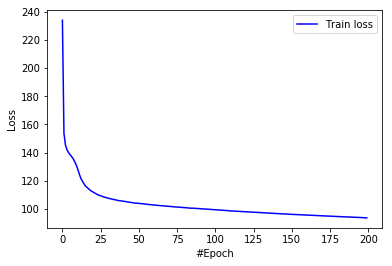

In [9]:
train_loss = autoencoder.log['train_loss']

plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

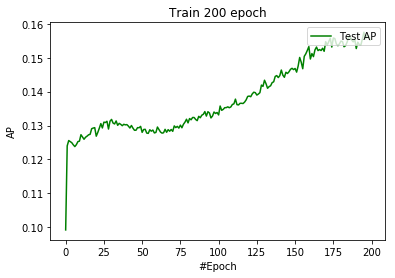

0.15751107702794834


In [10]:
test_ap = autoencoder.log['ap@5']

plt.plot(range(len(test_ap)), test_ap, color='green', label='Test AP')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.title("Train 200 epoch")
plt.xlabel('#Epoch')
plt.ylabel('AP')
plt.show()

print (max(test_ap))

In [11]:
user_onehot_vectors = autoencoder.sess.run(autoencoder.vector_matrix)

np.save('../data/itri/user_itri_vectors.npy', user_onehot_vectors)

# Item Perspective

In [ ]:
train_rating, train_indices, test_indices = gen_train_test(item_rating)

tf.reset_default_graph()

autoencoder = AutoEncoder(user_num=total_usr, item_num=total_item, mode='item', loss_function='log_loss',
                          epochs=200)
autoencoder.train(rating=train_rating,
                  train_indices=train_indices,
                  test_indices=test_indices)

train_loss = autoencoder.log['train_loss']

plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
test_ap = autoencoder.log['ap@5']

plt.plot(range(len(test_ap)), test_ap, color='green', label='Test AP')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.title("Train 5000 epoch")
plt.xlabel('#Epoch')
plt.ylabel('AP')
plt.show()

print (test_ap.index(max(test_ap)), max(test_ap))

In [ ]:
item_onehot_vectors = autoencoder.sess.run(autoencoder.vector_matrix)

np.save('../data/itri/item_itri_non_pruned_vectors.npy', item_onehot_vectors)

## MAP@5

In [ ]:
recon = autoencoder.decode.eval(
    session=autoencoder.sess,
    feed_dict={
        autoencoder.input: [train_rating[1]],
        autoencoder.ident: 1
    })

print (recon)

In [ ]:
aps = []

for usr in range(user_rating.shape[0]):
    recon = autoencoder.decode.eval(
        session=autoencoder.sess,
        feed_dict={
            autoencoder.input: [train_rating[usr]],
            autoencoder.ident: usr
        })
    
    top5 = get_topN(recon, train_indices[usr])
    
    aps.append(avg_precision(top5, test_indices[usr]))

print ("MAP: %f" % (sum(aps)/len(aps)))

## MAP@5 Top10 and HitRatio

In [ ]:
pop_top10 = rank[:10]
pop_top20 = rank[:20]
pop10_aps = []
hit_rates_10 = []
pop20_aps = []
hit_rates_20 = []

def hit_ratio(topN, indices):
    N = len(topN)
    hit_count = 0
    
    for i in range(N):
        hit_count += 1 if topN[i] in indices else 0
    
    try:
        return hit_count / min(N, len(indices))
    except ZeroDivisionError:
        return 0

for usr in range(user_rating.shape[0]):
    recon = autoencoder.decode.eval(
        session=autoencoder.sess,
        feed_dict={
            autoencoder.input: [train_rating[usr]],
            autoencoder.ident: usr
        })
    
    top5 = get_topN(recon, train_indices[usr])
    
    pop10_top5 = [x for x in top5 if x in pop_top10]
    pop10_test_index = [x for x in test_indices[usr] if x in pop_top10]
    
    pop20_top5 = [x for x in top5 if x in pop_top20]
    pop20_test_index = [x for x in test_indices[usr] if x in pop_top20]
    
    rate_10 = hit_ratio(pop10_top5, pop10_test_index)
    ap_10 = avg_precision(pop10_top5, pop10_test_index)
    
    rate_20 = hit_ratio(pop20_top5, pop20_test_index)
    ap_20 = avg_precision(pop20_top5, pop20_test_index)
    
    if ap_10 <= 1:
        pop10_aps.append(ap_10)
        hit_rates_10.append(rate_10)
        
    if ap_20 <= 1:
        pop20_aps.append(ap_20)
        hit_rates_20.append(rate_20)


print ("MAP in Popular Top 10: {0:.3f}%".format(sum(pop10_aps)/len(pop10_aps)*100))
print ("HIT_RATE in Popular Top 10: {0:.3f}%".format(sum(hit_rates_10)/len(hit_rates_10)*100))
print ()
print ("MAP in Popular Top 20: {0:.3f}%".format(sum(pop20_aps)/len(pop20_aps)*100))
print ("HIT_RATE in Popular Top 20: {0:.3f}%".format(sum(hit_rates_20)/len(hit_rates_20)*100))
